In [31]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Lambda
import numpy as np
import sklearn.utils as op
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from keras.utils import np_utils,pad_sequences
import keras.backend as K
import tensorflow as tf

# Data preparation

In [82]:
data=open("./CBOW.txt")


In [83]:
test=[text for text in data]


In [84]:
test[0]

'The speed of transmission is an important point of difference between the two viruses. Influenza has a shorter median incubation period (the time from infection to appearance of symptoms) and a shorter serial interval (the time between successive cases) than COVID-19 virus. The serial interval for COVID-19 virus is estimated to be 5-6 days, while for influenza virus, the serial interval is 3 days. This means that influenza can spread faster than COVID-19. \n'

# Generate Training data

In [7]:
token=Tokenizer()
token.fit_on_texts(test)

In [8]:
word2i=token.word_index

In [9]:
print(word2i)

{'the': 1, 'of': 2, 'influenza': 3, 'covid': 4, '19': 5, 'virus': 6, 'for': 7, 'transmission': 8, 'is': 9, 'to': 10, 'a': 11, 'and': 12, 'between': 13, 'time': 14, 'serial': 15, 'interval': 16, 'than': 17, 'be': 18, '5': 19, 'days': 20, '–': 21, 'are': 22, 'viruses': 23, 'shorter': 24, 'from': 25, 'appearance': 26, 'symptoms': 27, 'while': 28, '3': 29, 'this': 30, 'that': 31, 'can': 32, 'in': 33, 'major': 34, 'driver': 35, 'number': 36, '2': 37, 'speed': 38, 'an': 39, 'important': 40, 'point': 41, 'difference': 42, 'two': 43, 'has': 44, 'median': 45, 'incubation': 46, 'period': 47, 'infection': 48, 'successive': 49, 'cases': 50, 'estimated': 51, '6': 52, 'means': 53, 'spread': 54, 'faster': 55, 'further': 56, 'first': 57, 'illness': 58, 'or': 59, 'potentially': 60, 'pre': 61, 'symptomatic': 62, '–transmission': 63, 'before': 64, 'contrast': 65, 'we': 66, 'learning': 67, 'there': 68, 'people': 69, 'who': 70, 'shed': 71, '24': 72, '48': 73, 'hours': 74, 'prior': 75, 'symptom': 76, 'onset

In [15]:
corpus=token.texts_to_sequences(test)
word2i['PAD']=0

In [14]:
id2word={k:i for i,k in word2i.items()}

In [16]:
vocab_size=len(word2i)
embed_size=1000
window_size=2

In [43]:
def gen(corpus,win_s,voclen):
    mxl=win_s*2
    for words in corpus:
        wordl=len(words)
        for index,word in enumerate(words):
            con=[]
            st=index-window_size
            end=index+window_size+1
            lab=[]
            con.append([words[i] for i in range(st,end) if 0<=i<wordl & i!=index])
            lab.append(word)
            x=pad_sequences(con,maxlen=mxl)
            y=np_utils.to_categorical(lab,voclen)
            yield(x,y)

# Model training

In [69]:
cbow= Sequential()
cbow.add(Embedding(input_dim=vocab_size,output_dim=embed_size,input_length=window_size*2))
cbow.add(Lambda(lambda y: K.mean(y,axis=1),output_shape=(embed_size,)))
cbow.add(Dense(vocab_size,activation="relu"))



In [70]:
cbow.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 4, 1000)           103000    
                                                                 
 lambda_6 (Lambda)           (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 103)               103103    
                                                                 
Total params: 206,103
Trainable params: 206,103
Non-trainable params: 0
_________________________________________________________________


In [71]:
cbow.compile(loss="categorical_crossentropy", optimizer="adadelta")

In [72]:
losses=[]
for i in range(10):
    loss=0
    for x,y in gen(corpus,window_size,vocab_size):
        loss+=cbow.train_on_batch(x,y)
    losses.append(loss)
    print("Epooch: {} \t Loss: {}".format(i+1,loss))

Epooch: 1 	 Loss: 1845.1739621162415
Epooch: 2 	 Loss: 1840.264280796051
Epooch: 3 	 Loss: 1837.7488074302673
Epooch: 4 	 Loss: 1835.3373048305511
Epooch: 5 	 Loss: 1833.020281791687
Epooch: 6 	 Loss: 1831.1028909683228
Epooch: 7 	 Loss: 1829.3567471504211
Epooch: 8 	 Loss: 1827.6797578334808
Epooch: 9 	 Loss: 1826.0653283596039
Epooch: 10 	 Loss: 1824.5085606575012


# Predict

In [73]:
weights=cbow.get_weights()[0]
weights.shape

(103, 1000)

In [74]:
dismat=euclidean_distances(weights)
dismat.shape

(103, 103)

# output

In [35]:
similar_terms={term: [id2word[idx] for idx in dismat[word2i[term]-1].argsort()[1:6]+1] for term in ["potentially"]}

In [36]:
similar_terms

{'potentially': ['than', 'can', 'viruses', '5', 'virus']}

# Plotting

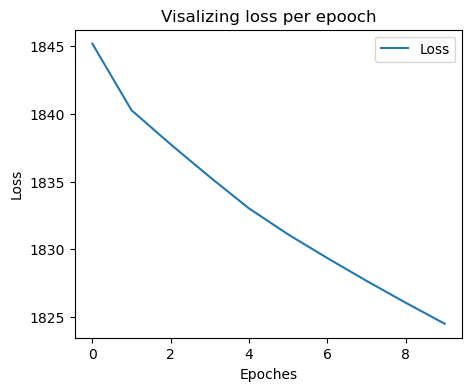

In [78]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(0,10),losses,label="Loss")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.title("Visalizing loss per epooch")
plt.legend()